In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# Novel rankings, by raw alignment counts

In [5]:
from sqlalchemy import func

from quotes.models import ChadhNovel, Alignment
from quotes.services import session

count = func.count(Alignment.a_id)

alignment_counts = (
    session
    .query(ChadhNovel.slug, count)
    .join(Alignment)
    .filter(Alignment.size >= 5)
    .group_by(ChadhNovel.slug)
    .order_by(count.desc())
)

In [6]:
for slug, count in alignment_counts:
    print(slug, count)

Chadwyck_British_1863_Reade_HardCashA 6818
Chadwyck_British_1862_Collins_NoNameBy 6652
Chadwyck_British_1862_Braddon_LadyAudleySecret 5785
Chadwyck_British_1868_Collins_TheMoonstoneA 4485
Chadwyck_British_1859_Collins_TheWomanin 4443
Chadwyck_Irish_1864_Le Fanu_UncleSilasA 4173
Chadwyck_British_1850_Bell_TheLadderof 3893
Chadwyck_British_1839_Ainsworth_JackSheppardA 3769
Chadwyck_British_1861_Dickens_GreatExpectationsBy 3600
Chadwyck_British_1874_Hardy_Farfromthe 3358
Chadwyck_British_1838_Dickens_OliverTwistor 3233
Chadwyck_British_1883_Broughton_BelindaANovel 3177
Chadwyck_British_1861_Wood_EastLynneBy 3061
Chadwyck_British_1880_Trollope_TheDukeChildren 3032
Chadwyck_British_1878_Hardy_TheReturnof 2996
Chadwyck_British_1863_Eliot_RomolaByGeorge 2850
Chadwyck_British_1862_Thackeray_TheAdventuresof 2722
Chadwyck_British_1854_Dickens_HardTimesFor 2590
Chadwyck_British_1891_Hardy_Tessofthe 2513
Chadwyck_British_1866_Collins_ArmadaleByWilkie 2490
Chadwyck_British_1819_Scott_IvanhoeARomanc

# Alignment size distribution

In [3]:
from collections import OrderedDict

size_counts = OrderedDict(
    session
    .query(Alignment.size, func.count(Alignment.a_id))
    .filter(Alignment.size >= 5)
    .group_by(Alignment.size)
    .order_by(Alignment.size.desc())
    .all()
)

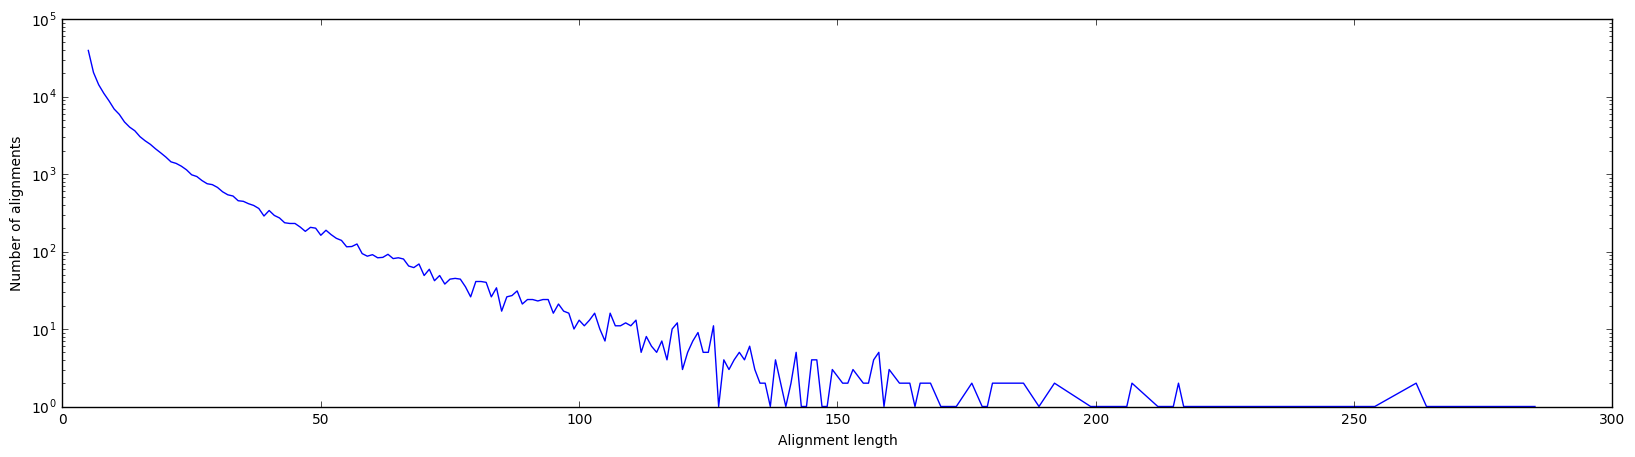

In [4]:
plt.figure(figsize=(20, 5))
plt.xlabel('Alignment length')
plt.ylabel('Number of alignments')
plt.yscale('log')

plt.plot(
    list(size_counts.keys()),
    list(size_counts.values()),
)

plt.show()

# Total BPO article length by year

In [ ]:
from quotes.models import BPOArticle

def bpo_article_len(year):

    articles = (
        session
        .query(BPOArticle)
        .filter_by(year=year)
        .subquery()
    )

    return (
        session
        .query(func.sum(func.length(articles.c.text)), articles)
        .scalar()
    )

In [ ]:
bpo_years = [r[0] for r in (
    session
    .query(func.distinct(BPOArticle.year))
    .all()
)]

bpo_year_lens = {}
for year in bpo_years:
    bpo_year_lens[year] = bpo_article_len(year)
    print(year)